<a href="https://colab.research.google.com/github/FabianC22/Dimplomado_Ciencia_Datos/blob/main/Proyecto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import scandir 
import pandas as pd
import numpy as np
from pandas import ExcelWriter

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns

# modelado
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras


In [2]:
# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]



In [4]:
name_excel='Cancer.xlsx'
sheet='METABRIC_RNA_Mutation'
Datos_General=pd.read_excel(name_excel, sheet,index_col="patient_id")

In [5]:
#cantidad de NaN en el data set
total = Datos_General.isnull().sum().sort_values(ascending = False)
percent = (Datos_General.isnull().sum() / Datos_General.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(14)


,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
neoplasm_histologic_grade,72,0.037815
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
oncotree_code,15,0.007878


In [6]:
clinical_features_to_drop = Datos_General.columns[30:] # non clinical attributes
clinical_Datos_General = Datos_General.drop(clinical_features_to_drop, axis=1)
clinical_Datos_General.head()    

clinical_Datos_General.info()    

clinical_Datos_General = clinical_Datos_General.dropna()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 7299
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_at_diagnosis                1904 non-null   float64
 1   type_of_breast_surgery          1882 non-null   object 
 2   cancer_type                     1904 non-null   object 
 3   cancer_type_detailed            1889 non-null   object 
 4   cellularity                     1850 non-null   object 
 5   chemotherapy                    1904 non-null   int64  
 6   pam50_+_claudin-low_subtype     1904 non-null   object 
 7   cohort                          1904 non-null   int64  
 8   er_status_measured_by_ihc       1874 non-null   object 
 9   er_status                       1904 non-null   object 
 10  neoplasm_histologic_grade       1832 non-null   float64
 11  her2_status_measured_by_snp6    1904 non-null   object 
 12  her2_status                     19

In [7]:
### convertir a variables Dummy las categoricas
type_of_breast_surgery = pd.get_dummies(clinical_Datos_General['type_of_breast_surgery']) #
cancer_type = pd.get_dummies(clinical_Datos_General['cancer_type'])#
cancer_type_detailed= pd.get_dummies(clinical_Datos_General['cancer_type_detailed']) #
cellularity= pd.get_dummies(clinical_Datos_General['cellularity']) #
clinical_Datos_General['pam50_+_claudin-low_subtype'] = clinical_Datos_General['pam50_+_claudin-low_subtype'].rename('pam50_claudin low_subtype')
pam50_claudin_low_subtype= pd.get_dummies(clinical_Datos_General['pam50_+_claudin-low_subtype']) #
er_status_measured_by_ihc= pd.get_dummies(clinical_Datos_General['er_status_measured_by_ihc']) #
er_status = pd.get_dummies(clinical_Datos_General['er_status']) #
her2_status_measured_by_snp6 = pd.get_dummies(clinical_Datos_General['her2_status_measured_by_snp6']) #
her2_status= pd.get_dummies(clinical_Datos_General['her2_status']) #
tumor_other_histologic_subtype= pd.get_dummies(clinical_Datos_General['tumor_other_histologic_subtype']) #
inferred_menopausal_state = pd.get_dummies(clinical_Datos_General["inferred_menopausal_state"])#
integrative_cluster = pd.get_dummies(clinical_Datos_General['integrative_cluster']) #
primary_tumor_laterality = pd.get_dummies(clinical_Datos_General['primary_tumor_laterality']) #
oncotree_code = pd.get_dummies(clinical_Datos_General['oncotree_code']) #
pr_status= pd.get_dummies(clinical_Datos_General['pr_status']) #
three_gene_classifier_subtype = pd.get_dummies(clinical_Datos_General['3-gene_classifier_subtype'])
death_from_cancer = pd.get_dummies(clinical_Datos_General['death_from_cancer'])
result = pd.concat([type_of_breast_surgery, cancer_type,
                    cancer_type_detailed,cellularity,
                    pam50_claudin_low_subtype,er_status_measured_by_ihc,
                    er_status,her2_status_measured_by_snp6,her2_status,
                    tumor_other_histologic_subtype,inferred_menopausal_state,
                    integrative_cluster,primary_tumor_laterality,oncotree_code,
                    pr_status,three_gene_classifier_subtype,death_from_cancer],axis=1 )

Target=pd.DataFrame(clinical_Datos_General["overall_survival"],index=clinical_Datos_General.index)

Datos=clinical_Datos_General.drop(['type_of_breast_surgery','cancer_type','cancer_type_detailed',
                                   'cellularity','pam50_+_claudin-low_subtype','er_status_measured_by_ihc',
                                   'er_status','her2_status_measured_by_snp6', 'her2_status',
                                   'tumor_other_histologic_subtype',"inferred_menopausal_state",
                                   'integrative_cluster','primary_tumor_laterality','oncotree_code',
                                   'pr_status','3-gene_classifier_subtype','death_from_cancer',"overall_survival"], axis=1)


Datos=pd.concat([Datos,result,Target],axis=1)

In [8]:
##### dividir los datos en entrenamiento y prueba

X_train, X_test, Y_train, Y_test = train_test_split(Datos.iloc[0:,:76],
                                             Datos["overall_survival"], random_state=36545808,
                                             test_size=0.3, shuffle=False)


X_train=X_train.astype("float")
X_test=X_test.astype("float")


In [11]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.3 MB/s eta 0:00:00


In [12]:
############## Red Neuronal para historial clinico ###################

########### Tuning ##########

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer='adam',
        metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    )
    return model

build_model(kt.HyperParameters())

In [18]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="C:/Users/fabia/OneDrive/Documentos/UNAL/IA/salida",
    project_name="modelo",
)

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [20]:
tuner_RandomSearch_mlp.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 03s]
val_loss: 0.46929502487182617

Best val_loss So Far: 0.0005405099946074188
Total elapsed time: 00h 01m 26s


In [22]:
best_hps=tuner_RandomSearch_mlp.get_best_hyperparameters(num_trials=1)[0]
best_hps

In [23]:
### entrenar el modelo

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_RandomSearch_mlp.hypermodel.build(best_hps)

history = model.fit(X_train, Y_train, epochs=50, validation_split=0.2)


Epoch 1/50
20/20 [==============================] - 4s 69ms/step - loss: 0.6955 - accuracy: 0.6236 - precision: 0.6093 - recall: 0.7524 - val_loss: 0.6456 - val_accuracy: 0.5425 - val_precision: 0.4071 - val_recall: 0.9388
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5879 - accuracy: 0.6939 - precision: 0.6839 - recall: 0.7556 - val_loss: 0.4762 - val_accuracy: 0.7778 - val_precision: 0.6154 - val_recall: 0.8163
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5984 - accuracy: 0.6972 - precision: 0.6923 - recall: 0.7429 - val_loss: 0.5603 - val_accuracy: 0.6993 - val_precision: 0.5172 - val_recall: 0.9184
Epoch 4/50
20/20 [==============================] - 0s 14ms/step - loss: 0.5660 - accuracy: 0.7119 - precision: 0.6894 - recall: 0.8032 - val_loss: 0.5872 - val_accuracy: 0.6144 - val_precision: 0.4510 - val_recall: 0.9388
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5908 - accuracy: 0.6890 - precisi

In [24]:
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best epoch: 32


In [35]:
hypermodel = tuner_RandomSearch_mlp.hypermodel.build(best_hps)

In [46]:
hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/32
20/20 [==============================] - 2s 27ms/step - loss: 0.7676 - accuracy: 0.6547 - precision: 0.7047 - recall: 0.5683 - val_loss: 2.5040 - val_accuracy: 0.4771 - val_precision: 0.3798 - val_recall: 1.0000
Epoch 2/32
20/20 [==============================] - 0s 13ms/step - loss: 0.7444 - accuracy: 0.6236 - precision: 0.6375 - recall: 0.6254 - val_loss: 0.6549 - val_accuracy: 0.6405 - val_precision: 0.4694 - val_recall: 0.9388
Epoch 3/32
20/20 [==============================] - 0s 14ms/step - loss: 0.6116 - accuracy: 0.6628 - precision: 0.6940 - recall: 0.6190 - val_loss: 0.7349 - val_accuracy: 0.5752 - val_precision: 0.4259 - val_recall: 0.9388
Epoch 4/32
20/20 [==============================] - 0s 14ms/step - loss: 0.5764 - accuracy: 0.7234 - precision: 0.7051 - recall: 0.7968 - val_loss: 0.7210 - val_accuracy: 0.6144 - val_precision: 0.4510 - val_recall: 0.9388
Epoch 5/32
20/20 [==============================] - 0s 13ms/step - loss: 0.5708 - accuracy: 0.7218 - precisi

In [72]:
hypermodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 288)               22176     
                                                                 
 dense_41 (Dense)            (None, 544)               157216    
                                                                 
 dense_42 (Dense)            (None, 384)               209280    
                                                                 
 dense_43 (Dense)            (None, 416)               160160    
                                                                 
 dense_44 (Dense)            (None, 32)                13344     
                                                                 
 dense_45 (Dense)            (None, 32)                1056      
                                                                 
 dense_46 (Dense)            (None, 1)                

In [47]:
eval_result = hypermodel.evaluate(X_test, Y_test)

11/11 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9939 - precision: 1.0000 - recall: 0.9833


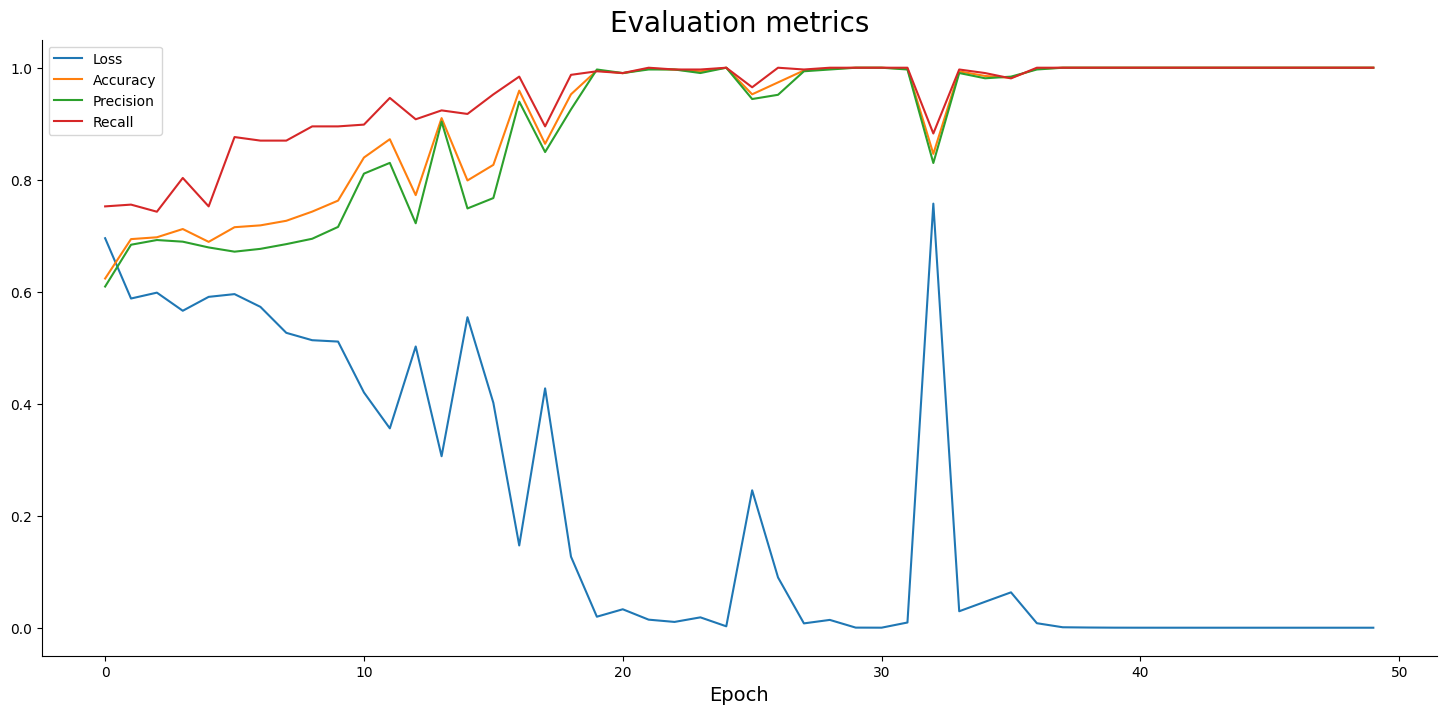

In [48]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False


plt.plot(
    #np.arange(1, 3), 
    history.history['loss'], label='Loss'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history.history['precision'], label='Precision'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Obtener las predicciones del modelo para los datos de prueba
y_pred = hypermodel.predict(X_test) 

prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(y_pred)
]

# Calcular la precisión
accuracy = accuracy_score(Y_test,prediction_classes)
print('Precisión en los datos de prueba:', accuracy)

# Calcular la matriz de confusión
confusion = confusion_matrix(Y_test,prediction_classes)
print('Matriz de confusión:')
print(confusion)


11/11 [==============================] - 0s 5ms/step
Precisión en los datos de prueba: 0.9939024390243902
Matriz de confusión:
[[208   0]
 [  2 118]]


In [50]:

############## Ramdon Forest para historial clinico ###################


random_state_v2 = 254605
N=5
nIter = 25
kf = RepeatedStratifiedKFold(n_splits=N, n_repeats=10, random_state=random_state_v2)
AUC_DATA_RF=pd.DataFrame(columns=['Variable criterion', 'Variable n_estimators',
                                  'Variable max_features', 'Variable max_depth',
                                  'Variable min_samples_split', 'Variable min_samples_leaf','MEDIA_RF','STD_RF'],index=range(1,1+nIter))

# Parametros de tuning RF
criterion = ['gini', 'entropy']
n_estimators = np.arange(50,1000,10)
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)];max_depth.append(None)
# min_samples_split = [int(x) for x in np.linspace(4, 40, num = 18)]
min_samples_split = np.concatenate([[0.01], np.linspace(0.1,1,10)])  
# min_samples_leaf = [x for x in np.linspace(start = 0, stop = 1, num = 50)]
min_samples_leaf = np.concatenate([[0.01], np.linspace(0.1,0.5,5)])  

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
                'max_features': max_features, 
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}     
#Ramdon forest base  
random_forest = RandomForestClassifier(min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.                                
                            max_leaf_nodes=None, # Maximum number of nodes.
                            # max_depth=None, # Max depth of the trees. Not necessary to change.
                            min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                            bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                            oob_score=True,  # If report accuracy with non-selected cases.
                            n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                            random_state=random_state_v2, # Seed
                            verbose=0, # If to give info during training. Set to 0 for silent training.
                            warm_start=False, # If train over previously trained tree.
                            class_weight='balanced')      


random_forestTuning = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = nIter, cv = kf, verbose=1, random_state=random_state_v2, n_jobs = -1, scoring='roc_auc')
random_forestTuning.fit(X_train,Y_train)

 # Resultados
cvres2 = random_forestTuning.cv_results_ 
for i in range(1, nIter+1):
    AUC_DATA_RF['Variable criterion'][i] = cvres2['params'][i-1]['criterion']
    AUC_DATA_RF['Variable n_estimators'][i] = cvres2['params'][i-1]['n_estimators']
    AUC_DATA_RF['Variable max_features'][i] = cvres2['params'][i-1]['max_features']
    AUC_DATA_RF['Variable max_depth'][i] = cvres2['params'][i-1]['max_depth']
    AUC_DATA_RF['Variable min_samples_split'][i] = cvres2['params'][i-1]['min_samples_split']
    AUC_DATA_RF['Variable min_samples_leaf'][i] = cvres2['params'][i-1]['min_samples_leaf']
    AUC_DATA_RF['MEDIA_RF'][i] = cvres2['mean_test_score'][i-1]
    AUC_DATA_RF['STD_RF'][i] = cvres2['std_test_score'][i-1]


try:   
    RF_BestCho=np.array(AUC_DATA_RF.iloc[np.where(np.max(AUC_DATA_RF.iloc[:,6])==AUC_DATA_RF.iloc[:,6])[0],0:6])[0]
except:
    RF_BestCho = np.nan
print('La configuración RF que genera mejor AUC es '+str(RF_BestCho))
   


Fitting 50 folds for each of 25 candidates, totalling 1250 fits
La configuración RF que genera mejor AUC es ['gini' 120 'log2' 80 0.1 0.01]


In [52]:
  
###########################################  Predicción RF ##################################################   
random_forest = RandomForestClassifier(criterion = RF_BestCho[0],
                                           n_estimators = RF_BestCho[1],
                                           max_features = RF_BestCho[2], 
                                           max_depth = RF_BestCho[3],
                                           min_samples_split = RF_BestCho[4],
                                           min_samples_leaf = RF_BestCho[5],
                                           min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                                           max_leaf_nodes=None, # Maximum number of nodes.                                               
                                           min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                                           bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                                           oob_score=True,  # If report accuracy with non-selected cases.
                                           n_jobs=1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                                           random_state=random_state_v2, # Seed
                                           verbose=0, # If to give info during training. Set to 0 for silent training.
                                           warm_start=False, # If train over previously trained tree.
                                           class_weight='balanced') 


result_hist = random_forest.fit(X_test,Y_test)


Y_pred_RF_prob_histo = random_forest.predict_proba(X_test)
Y_pred_RF_Estado_histo = random_forest.predict(X_test)


In [53]:

# Calcular la precisión
accuracy_RF = accuracy_score(Y_test,Y_pred_RF_Estado_histo)
print('Precisión en los datos de prueba:', accuracy_RF)


# Calcular la matriz de confusión
confusion_RF = confusion_matrix(Y_test,Y_pred_RF_Estado_histo)
print('Matriz de confusión:')
print(confusion_RF)

Precisión en los datos de prueba: 1.0
Matriz de confusión:
[[208   0]
 [  0 120]]


In [73]:

############## Red Neuronal para expresion genetica ###################


clinical_history_to_drop = Datos_General.columns[:30] # non clinical attributes
expresion_Datos_General = Datos_General.drop(clinical_history_to_drop, axis=1)
expresion_Datos_General.head()    
expresion_Datos_General.info()    
expresion_Datos_General = expresion_Datos_General.dropna()
Datos_expre=pd.concat([expresion_Datos_General,Target],axis=1)
Datos_expre = Datos_expre.dropna()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 7299
Columns: 488 entries, brca1 to ugt2b7
dtypes: float64(488)
memory usage: 7.2 MB


In [55]:

##### dividir los datos en entrenamiento y prueba

X_train_expre, X_test_expre, Y_train_expre, Y_test_expre = train_test_split(Datos_expre.iloc[0:,:488],
                                             Datos_expre["overall_survival"], random_state=36545808,
                                             test_size=0.3, shuffle=False)


X_train_expre=X_train_expre.astype("float")
X_test_expre=X_test_expre.astype("float")


In [56]:


################### Tuning

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers



def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer='adam',
        metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    )
    return model

build_model(kt.HyperParameters())

In [57]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="C:/Users/fabia/OneDrive/Documentos/UNAL/IA/salida",
    project_name="modelo1",
)


In [58]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [59]:
tuner_RandomSearch_mlp.search(X_train_expre, Y_train_expre, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 10 Complete [00h 00m 05s]
val_loss: 0.6817265152931213

Best val_loss So Far: 0.6389109492301941
Total elapsed time: 00h 00m 42s


In [60]:
best_hps_expre=tuner_RandomSearch_mlp.get_best_hyperparameters(num_trials=1)[0]


In [62]:

### entrenar el modelo

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_expre = tuner_RandomSearch_mlp.hypermodel.build(best_hps_expre)


In [63]:
history_expre = model_expre.fit(X_train_expre, Y_train_expre, epochs=50, validation_split=0.2)


Epoch 1/50
20/20 [==============================] - 3s 27ms/step - loss: 0.6995 - accuracy: 0.5057 - precision: 0.5212 - recall: 0.5079 - val_loss: 0.6760 - val_accuracy: 0.5490 - val_precision: 0.3438 - val_recall: 0.4490
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.5593 - accuracy: 0.7283 - precision: 0.7110 - recall: 0.7968 - val_loss: 0.6864 - val_accuracy: 0.5948 - val_precision: 0.3968 - val_recall: 0.5102
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.3148 - accuracy: 0.8822 - precision: 0.8762 - recall: 0.8984 - val_loss: 1.2581 - val_accuracy: 0.5686 - val_precision: 0.3509 - val_recall: 0.4082
Epoch 4/50
20/20 [==============================] - 0s 12ms/step - loss: 0.1083 - accuracy: 0.9607 - precision: 0.9709 - recall: 0.9524 - val_loss: 1.9037 - val_accuracy: 0.5163 - val_precision: 0.3418 - val_recall: 0.5510
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0378 - accuracy: 0.9902 - precisi

In [64]:
val_acc_per_epoch = history_expre.history['val_loss']
best_epoch_expre = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch_expre,))

Best epoch: 50


In [66]:
hypermodel_expre = tuner_RandomSearch_mlp.hypermodel.build(best_hps_expre)

In [67]:
hypermodel_expre.fit(X_train_expre, Y_train_expre, epochs=best_epoch_expre, validation_split=0.2)


Epoch 1/50
20/20 [==============================] - 2s 26ms/step - loss: 0.6870 - accuracy: 0.5630 - precision: 0.5628 - recall: 0.6825 - val_loss: 0.6956 - val_accuracy: 0.5621 - val_precision: 0.3393 - val_recall: 0.3878
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5873 - accuracy: 0.7005 - precision: 0.6746 - recall: 0.8095 - val_loss: 0.6922 - val_accuracy: 0.5882 - val_precision: 0.3906 - val_recall: 0.5102
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.3652 - accuracy: 0.8642 - precision: 0.8602 - recall: 0.8794 - val_loss: 1.0995 - val_accuracy: 0.6078 - val_precision: 0.4225 - val_recall: 0.6122
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.1750 - accuracy: 0.9362 - precision: 0.9452 - recall: 0.9302 - val_loss: 1.7133 - val_accuracy: 0.5359 - val_precision: 0.3690 - val_recall: 0.6327
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0890 - accuracy: 0.9640 - precisi

In [68]:
hypermodel_expre.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 160)               78240     
                                                                 
 dense_29 (Dense)            (None, 192)               30912     
                                                                 
 dense_30 (Dense)            (None, 288)               55584     
                                                                 
 dense_31 (Dense)            (None, 32)                9248      
                                                                 
 dense_32 (Dense)            (None, 544)               17952     
                                                                 
 dense_33 (Dense)            (None, 448)               244160    
                                                                 
 dropout_4 (Dropout)         (None, 448)              

In [69]:
eval_result_expre = hypermodel_expre.evaluate(X_test_expre, Y_test_expre)


11/11 [==============================] - 0s 4ms/step - loss: 5.6715 - accuracy: 0.5061 - precision: 0.3654 - recall: 0.4750


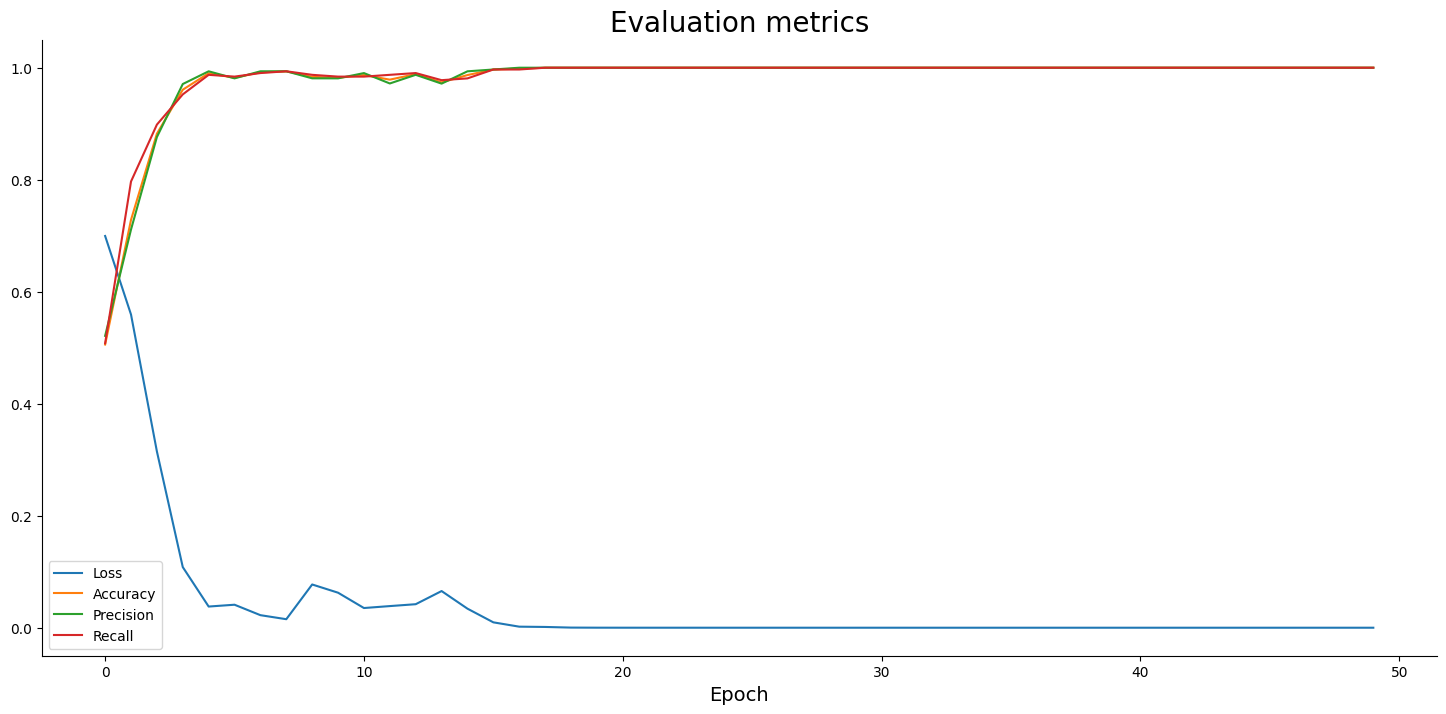

In [70]:

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False


plt.plot(
    #np.arange(1, 3), 
    history_expre.history['loss'], label='Loss'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_expre.history['accuracy'], label='Accuracy'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_expre.history['precision'], label='Precision'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_expre.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


In [71]:

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Obtener las predicciones del modelo para los datos de prueba
y_pred_expre = hypermodel_expre.predict(X_test_expre) 

prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(y_pred_expre)
]

# Calcular la precisión
accuracy = accuracy_score(Y_test_expre,prediction_classes)
print('Precisión en los datos de prueba:', accuracy)

# Calcular la matriz de confusión
confusion_expre = confusion_matrix(Y_test_expre,prediction_classes)
print('Matriz de confusión:')
print(confusion_expre)


11/11 [==============================] - 0s 5ms/step
Precisión en los datos de prueba: 0.5060975609756098
Matriz de confusión:
[[109  99]
 [ 63  57]]


In [74]:


############## Ramdon Forest para expresión genetica ###################


random_state_v2 = 254605
N=5
nIter = 25
kf = RepeatedStratifiedKFold(n_splits=N, n_repeats=10, random_state=random_state_v2)
AUC_DATA_RF=pd.DataFrame(columns=['Variable criterion', 'Variable n_estimators',
                                  'Variable max_features', 'Variable max_depth',
                                  'Variable min_samples_split', 'Variable min_samples_leaf','MEDIA_RF','STD_RF'],index=range(1,1+nIter))

# Parametros de tuning RF
criterion = ['gini', 'entropy']
n_estimators = np.arange(50,1000,10)
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)];max_depth.append(None)
# min_samples_split = [int(x) for x in np.linspace(4, 40, num = 18)]
min_samples_split = np.concatenate([[0.01], np.linspace(0.1,1,10)])  
# min_samples_leaf = [x for x in np.linspace(start = 0, stop = 1, num = 50)]
min_samples_leaf = np.concatenate([[0.01], np.linspace(0.1,0.5,5)])  

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
                'max_features': max_features, 
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}     
#Ramdon forest base  
random_forest = RandomForestClassifier(min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.                                
                            max_leaf_nodes=None, # Maximum number of nodes.
                            # max_depth=None, # Max depth of the trees. Not necessary to change.
                            min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                            bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                            oob_score=True,  # If report accuracy with non-selected cases.
                            n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                            random_state=random_state_v2, # Seed
                            verbose=0, # If to give info during training. Set to 0 for silent training.
                            warm_start=False, # If train over previously trained tree.
                            class_weight='balanced')      


random_forestTuning = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = nIter, cv = kf, verbose=1, random_state=random_state_v2, n_jobs = -1, scoring='roc_auc')
random_forestTuning.fit(X_train_expre,Y_train_expre)

 # Resultados
cvres2 = random_forestTuning.cv_results_ 
for i in range(1, nIter+1):
    AUC_DATA_RF['Variable criterion'][i] = cvres2['params'][i-1]['criterion']
    AUC_DATA_RF['Variable n_estimators'][i] = cvres2['params'][i-1]['n_estimators']
    AUC_DATA_RF['Variable max_features'][i] = cvres2['params'][i-1]['max_features']
    AUC_DATA_RF['Variable max_depth'][i] = cvres2['params'][i-1]['max_depth']
    AUC_DATA_RF['Variable min_samples_split'][i] = cvres2['params'][i-1]['min_samples_split']
    AUC_DATA_RF['Variable min_samples_leaf'][i] = cvres2['params'][i-1]['min_samples_leaf']
    AUC_DATA_RF['MEDIA_RF'][i] = cvres2['mean_test_score'][i-1]
    AUC_DATA_RF['STD_RF'][i] = cvres2['std_test_score'][i-1]


try:   
    RF_BestCho=np.array(AUC_DATA_RF.iloc[np.where(np.max(AUC_DATA_RF.iloc[:,6])==AUC_DATA_RF.iloc[:,6])[0],0:6])[0]
except:
    RF_BestCho = np.nan
print('La configuración RF que genera mejor AUC es '+str(RF_BestCho))
   


Fitting 50 folds for each of 25 candidates, totalling 1250 fits
La configuración RF que genera mejor AUC es ['entropy' 330 'sqrt' 70 0.2 0.01]


In [75]:
   
###########################################  Predicción RF ##################################################   
random_forest = RandomForestClassifier(criterion = RF_BestCho[0],
                                           n_estimators = RF_BestCho[1],
                                           max_features = RF_BestCho[2], 
                                           max_depth = RF_BestCho[3],
                                           min_samples_split = RF_BestCho[4],
                                           min_samples_leaf = RF_BestCho[5],
                                           min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                                           max_leaf_nodes=None, # Maximum number of nodes.                                               
                                           min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                                           bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                                           oob_score=True,  # If report accuracy with non-selected cases.
                                           n_jobs=1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                                           random_state=random_state_v2, # Seed
                                           verbose=0, # If to give info during training. Set to 0 for silent training.
                                           warm_start=False, # If train over previously trained tree.
                                           class_weight='balanced') 


result_expre = random_forest.fit(X_test_expre,Y_test_expre)


Y_pred_RF_prob_expre = random_forest.predict_proba(X_test_expre)
Y_pred_RF_Estado_expre = random_forest.predict(X_test_expre)


In [76]:
# Calcular la precisión
accuracy_RF_expre = accuracy_score(Y_test_expre,Y_pred_RF_Estado_expre)
print('Precisión en los datos de prueba:', accuracy_RF_expre)


# Calcular la matriz de confusión
confusion_RF_expre = confusion_matrix(Y_test_expre,Y_pred_RF_Estado_expre)
print('Matriz de confusión:')
print(confusion_RF_expre)


Precisión en los datos de prueba: 0.9908536585365854
Matriz de confusión:
[[208   0]
 [  3 117]]


In [77]:


############# Combinacion de variables predictoras ######

Datos_df=Datos.drop(["overall_survival"], axis=1)
Datos_General=pd.concat([Datos_df,Datos_expre],axis=1)


X_train_General, X_test_General, Y_train_General, Y_test_General = train_test_split(Datos_General.iloc[0:,:564],
                                             Datos_General["overall_survival"], random_state=36545808,
                                             test_size=0.3, shuffle=False)


X_train_General=X_train_General.astype("float")
X_test_General=X_test_General.astype("float")



In [78]:

################### Tuning

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers



def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer='adam',
        metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    )
    return model

build_model(kt.HyperParameters())


In [79]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="C:/Users/fabia/OneDrive/Documentos/UNAL/IA/salida",
    project_name="modelo3",
)

In [80]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [81]:
tuner_RandomSearch_mlp.search(X_train_General, Y_train_General, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 10 Complete [00h 00m 04s]
val_loss: 0.4715088903903961

Best val_loss So Far: 0.46145081520080566
Total elapsed time: 00h 00m 40s


In [82]:
best_hps_General=tuner_RandomSearch_mlp.get_best_hyperparameters(num_trials=1)[0]

In [83]:

### entrenar el modelo

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_General= tuner_RandomSearch_mlp.hypermodel.build(best_hps_General)

#model_General.summary()

history_General= model_General.fit(X_train_General, Y_train_General, epochs=50, validation_split=0.2)


Epoch 1/50
20/20 [==============================] - 3s 36ms/step - loss: 0.6861 - accuracy: 0.6841 - precision: 0.6894 - recall: 0.7048 - val_loss: 0.6817 - val_accuracy: 0.6471 - val_precision: 0.4742 - val_recall: 0.9388
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5095 - accuracy: 0.7578 - precision: 0.7251 - recall: 0.8540 - val_loss: 0.4895 - val_accuracy: 0.7712 - val_precision: 0.7917 - val_recall: 0.3878
Epoch 3/50
20/20 [==============================] - 0s 14ms/step - loss: 0.4648 - accuracy: 0.7578 - precision: 0.7720 - recall: 0.7524 - val_loss: 0.7490 - val_accuracy: 0.6732 - val_precision: 0.4944 - val_recall: 0.8980
Epoch 4/50
20/20 [==============================] - 0s 14ms/step - loss: 0.3912 - accuracy: 0.8200 - precision: 0.7824 - recall: 0.9016 - val_loss: 0.5041 - val_accuracy: 0.7778 - val_precision: 0.7586 - val_recall: 0.4490
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3094 - accuracy: 0.8642 - precisio

In [84]:
val_acc_per_epoch = history_General.history['val_loss']
best_epoch_General = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch_General,))


Best epoch: 50


In [85]:

hypermodel_General = tuner_RandomSearch_mlp.hypermodel.build(best_hps_General)


In [86]:
# Retrain the model
hypermodel_General.fit(X_train_General, Y_train_General, epochs=best_epoch_General, validation_split=0.2)

hypermodel_General.summary()

Epoch 1/50
20/20 [==============================] - 2s 22ms/step - loss: 0.6101 - accuracy: 0.6759 - precision: 0.6845 - recall: 0.6889 - val_loss: 0.5426 - val_accuracy: 0.7320 - val_precision: 0.5556 - val_recall: 0.8163
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5184 - accuracy: 0.7283 - precision: 0.7052 - recall: 0.8127 - val_loss: 0.4989 - val_accuracy: 0.7582 - val_precision: 0.6500 - val_recall: 0.5306
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4514 - accuracy: 0.7921 - precision: 0.8013 - recall: 0.7937 - val_loss: 0.5287 - val_accuracy: 0.7190 - val_precision: 0.5441 - val_recall: 0.7551
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3459 - accuracy: 0.8560 - precision: 0.8471 - recall: 0.8794 - val_loss: 0.5130 - val_accuracy: 0.7712 - val_precision: 0.6750 - val_recall: 0.5510
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.3300 - accuracy: 0.8625 - precision: 

In [87]:
eval_result_General = hypermodel_General.evaluate(X_test_General, Y_test_General)



11/11 [==============================] - 0s 3ms/step - loss: 1.7767 - accuracy: 0.7927 - precision: 0.6733 - recall: 0.8417


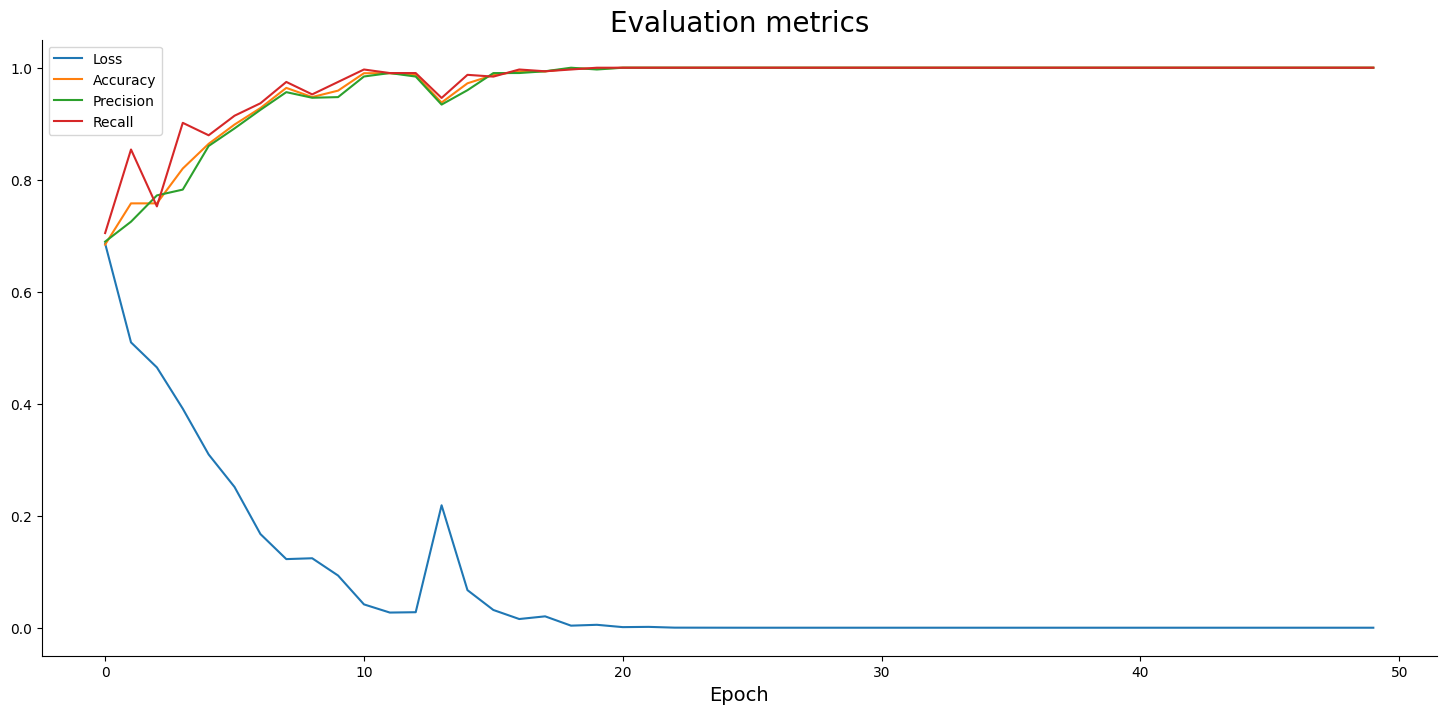

In [88]:

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False


plt.plot(
    #np.arange(1, 3), 
    history_General.history['loss'], label='Loss'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_General.history['accuracy'], label='Accuracy'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_General.history['precision'], label='Precision'
)
plt.plot(
    #np.arange(1, best_epoch), 
    history_General.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


In [89]:

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Obtener las predicciones del modelo para los datos de prueba
y_pred_General = hypermodel_General.predict(X_test_General) 

prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(y_pred_General)
]

# Calcular la precisión
accuracy = accuracy_score(Y_test_General,prediction_classes)
print('Precisión en los datos de prueba:', accuracy)

# Calcular la matriz de confusión
confusion_General = confusion_matrix(Y_test_General,prediction_classes)
print('Matriz de confusión:')
print(confusion_General)


11/11 [==============================] - 0s 2ms/step
Precisión en los datos de prueba: 0.7926829268292683
Matriz de confusión:
[[159  49]
 [ 19 101]]


In [90]:

############## Ramdon Forest para expresión genetica y historial clinico ###################


random_state_v2 = 254605
N=5
nIter = 25
kf = RepeatedStratifiedKFold(n_splits=N, n_repeats=10, random_state=random_state_v2)
AUC_DATA_RF=pd.DataFrame(columns=['Variable criterion', 'Variable n_estimators',
                                  'Variable max_features', 'Variable max_depth',
                                  'Variable min_samples_split', 'Variable min_samples_leaf','MEDIA_RF','STD_RF'],index=range(1,1+nIter))

# Parametros de tuning RF
criterion = ['gini', 'entropy']
n_estimators = np.arange(50,1000,10)
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)];max_depth.append(None)
# min_samples_split = [int(x) for x in np.linspace(4, 40, num = 18)]
min_samples_split = np.concatenate([[0.01], np.linspace(0.1,1,10)])  
# min_samples_leaf = [x for x in np.linspace(start = 0, stop = 1, num = 50)]
min_samples_leaf = np.concatenate([[0.01], np.linspace(0.1,0.5,5)])  

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
                'max_features': max_features, 
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}     
#Ramdon forest base  
random_forest = RandomForestClassifier(min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.                                
                            max_leaf_nodes=None, # Maximum number of nodes.
                            # max_depth=None, # Max depth of the trees. Not necessary to change.
                            min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                            bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                            oob_score=True,  # If report accuracy with non-selected cases.
                            n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                            random_state=random_state_v2, # Seed
                            verbose=0, # If to give info during training. Set to 0 for silent training.
                            warm_start=False, # If train over previously trained tree.
                            class_weight='balanced')      


random_forestTuning = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = nIter, cv = kf, verbose=1, random_state=random_state_v2, n_jobs = -1, scoring='roc_auc')
random_forestTuning.fit(X_train_General,Y_train_General)

 # Resultados
cvres2 = random_forestTuning.cv_results_ 
for i in range(1, nIter+1):
    AUC_DATA_RF['Variable criterion'][i] = cvres2['params'][i-1]['criterion']
    AUC_DATA_RF['Variable n_estimators'][i] = cvres2['params'][i-1]['n_estimators']
    AUC_DATA_RF['Variable max_features'][i] = cvres2['params'][i-1]['max_features']
    AUC_DATA_RF['Variable max_depth'][i] = cvres2['params'][i-1]['max_depth']
    AUC_DATA_RF['Variable min_samples_split'][i] = cvres2['params'][i-1]['min_samples_split']
    AUC_DATA_RF['Variable min_samples_leaf'][i] = cvres2['params'][i-1]['min_samples_leaf']
    AUC_DATA_RF['MEDIA_RF'][i] = cvres2['mean_test_score'][i-1]
    AUC_DATA_RF['STD_RF'][i] = cvres2['std_test_score'][i-1]


try:   
    RF_BestCho=np.array(AUC_DATA_RF.iloc[np.where(np.max(AUC_DATA_RF.iloc[:,6])==AUC_DATA_RF.iloc[:,6])[0],0:6])[0]
except:
    RF_BestCho = np.nan
print('La configuración RF que genera mejor AUC es '+str(RF_BestCho))
   


Fitting 50 folds for each of 25 candidates, totalling 1250 fits
La configuración RF que genera mejor AUC es ['entropy' 330 'sqrt' 70 0.2 0.01]


In [91]:
  
###########################################  Predicción RF ##################################################   
random_forest = RandomForestClassifier(criterion = RF_BestCho[0],
                                           n_estimators = RF_BestCho[1],
                                           max_features = RF_BestCho[2], 
                                           max_depth = RF_BestCho[3],
                                           min_samples_split = RF_BestCho[4],
                                           min_samples_leaf = RF_BestCho[5],
                                           min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                                           max_leaf_nodes=None, # Maximum number of nodes.                                               
                                           min_impurity_decrease=0.0003, # Minimum impurity decrease. This is 10^-3.
                                           bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                                           oob_score=True,  # If report accuracy with non-selected cases.
                                           n_jobs=1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                                           random_state=random_state_v2, # Seed
                                           verbose=0, # If to give info during training. Set to 0 for silent training.
                                           warm_start=False, # If train over previously trained tree.
                                           class_weight='balanced') 


result_expre = random_forest.fit(X_test_General,Y_test_General)


Y_pred_RF_prob_General = random_forest.predict_proba(X_test_General)
Y_pred_RF_Estado_General = random_forest.predict(X_test_General)


In [92]:
# Calcular la precisión
accuracy_RF_General = accuracy_score(Y_test_General,Y_pred_RF_Estado_General)
print('Precisión en los datos de prueba:', accuracy_RF_General)


# Calcular la matriz de confusión
confusion_RF_General = confusion_matrix(Y_test_General,Y_pred_RF_Estado_General)
print('Matriz de confusión:')
print(confusion_RF_General)




Precisión en los datos de prueba: 1.0
Matriz de confusión:
[[208   0]
 [  0 120]]
